<a href="https://colab.research.google.com/github/sanjana1976/Facial-Detection/blob/master/MNSIT_Digital_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import PyTorch and other relevant libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchsummary import summary

# MIT introduction to deep learning package
!pip install mitdeeplearning --quiet
import mitdeeplearning as mdl

# other packages
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 41.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.5/152.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.3/682.3 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 786.8/786.8 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.1/66.1 kB 5.8 MB/s eta 0:00:00


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [2]:
!pip install comet_ml > /dev/null 2>&1
import comet_ml
# TODO: ENTER YOUR API KEY HERE!!
COMET_API_KEY = "mfq8WTlM0gHW140OWD2A1vsC4"

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert torch.cuda.is_available(), "Please enable GPU from runtime settings"
assert COMET_API_KEY != "", "Please insert your Comet API Key"

# Set GPU for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.12/dist-packages/comet_ml/error_tracking/shutdown.py:22: SentryHubDeprecationWarning: `sentry_sdk.Hub` is deprecated and will be removed in a future major release. Please consult our 1.x to 2.x migration guide for details on how to migrate `Hub` usage to the new API: https://docs.sentry.io/platforms/python/migration/1.x-to-2.x
  client = sentry_sdk.Hub.current.client
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [3]:
# start a first comet experiment for the first part of the lab
comet_ml.init(project_name="6S191_lab2_part1_NN")
comet_model_1 = comet_ml.Experiment()

COMET WARNING: comet_ml.init() is deprecated and will be removed soon. Please use comet_ml.login()


Please paste your Comet API key from https://www.comet.com/api/my/settings/
(api key may not show as you type)
Comet API key: ··········


COMET INFO: Valid Comet API Key saved in /root/.comet.config (set COMET_CONFIG to change where it is saved).
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: tensorflow, sklearn, torch, keras.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/sanjana-jk/6s191-lab2-part1-nn/25d8badb8fa54a08b367ee0cb3ace214



In [4]:
# Download and transform the MNIST dataset
transform = transforms.Compose([
    # Convert images to PyTorch tensors which also scales data from [0,255] to [0,1]
    transforms.ToTensor()
])

# Download training and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 498kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.01MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.84MB/s]


In [5]:
image, label = train_dataset[0]
print(image.size())  # For a tensor: torch.Size([1, 28, 28])
print(label)

torch.Size([1, 28, 28])
5


{'web': 'https://www.comet.com/api/image/download?imageId=208ccd7547cc4a3396c9c2b8d56ef255&experimentKey=25d8badb8fa54a08b367ee0cb3ace214',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=208ccd7547cc4a3396c9c2b8d56ef255&experimentKey=25d8badb8fa54a08b367ee0cb3ace214',
 'imageId': '208ccd7547cc4a3396c9c2b8d56ef255'}

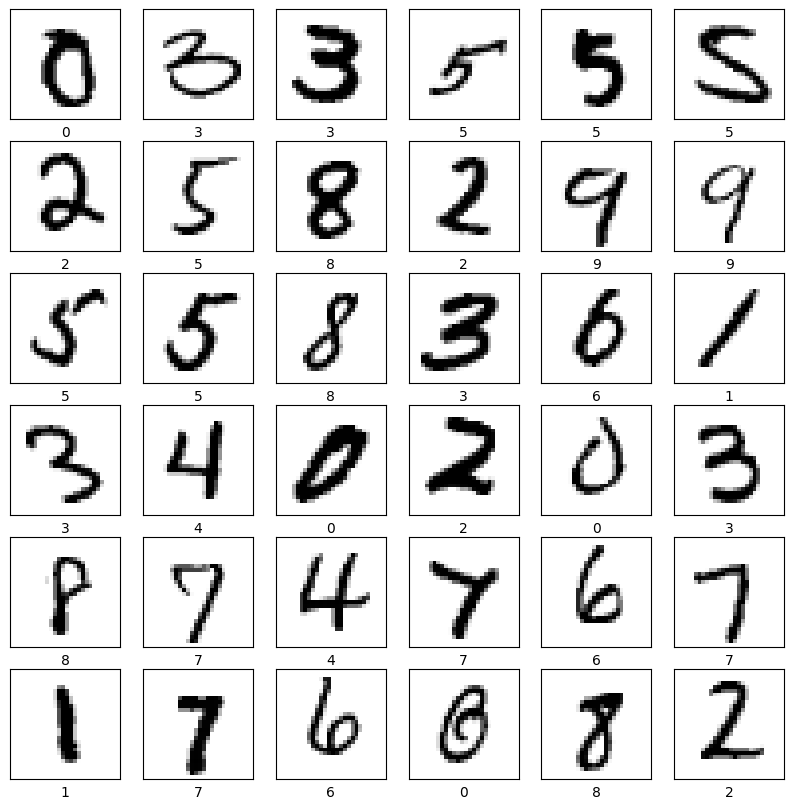

In [6]:
plt.figure(figsize=(10,10))
random_inds = np.random.choice(60000,36)
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    image, label = train_dataset[image_ind]
    plt.imshow(image.squeeze(), cmap=plt.cm.binary)
    plt.xlabel(label)
comet_model_1.log_figure(figure=plt)

In [7]:
def build_fc_model():
    fc_model = nn.Sequential(
        # Flatten the 28x28 image into a 784-length vector
        nn.Flatten(),

        # First fully connected layer + activation
        nn.Linear(28 * 28, 128),
        nn.ReLU(),  # Activation function for hidden layer

        # Second fully connected layer: output 10 class scores
        nn.Linear(128, 10),
        nn.Softmax(dim=1)  # Convert scores to probabilities
    )
    return fc_model

fc_model_sequential = build_fc_model()


In [8]:
# Define the fully connected model using nn.Module
class FullyConnectedModel(nn.Module):
    def __init__(self):
        super(FullyConnectedModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)

        # Activation function for the first fully connected layer
        self.relu = nn.ReLU()

        # Second Linear layer to output classification probabilities for 10 digits
        self.fc2 = nn.Linear(128, 10)
        self.softmax = nn.Softmax(dim=1)  # Convert raw scores to probabilities

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)      # Apply activation
        x = self.fc2(x)
        x = self.softmax(x)   # Convert to probability distribution
        return x

# Instantiate and move to GPU
fc_model = FullyConnectedModel().to(device)


In [9]:
# Create DataLoaders for batch processing
BATCH_SIZE = 64
trainset_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
testset_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(fc_model.parameters(), lr=0.1)

In [14]:
def train(model, dataloader, criterion, optimizer, epochs):
    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        total_loss = 0
        correct_pred = 0
        total_pred = 0

        for images, labels in trainset_loader:
            # Move tensors to GPU so compatible with model
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = fc_model(images)

            # Clear gradients before performing backward pass
            optimizer.zero_grad()
            # Calculate loss based on model predictions
            loss = loss_function(outputs, labels)
            # Backpropagate and update model parameters
            loss.backward()
            optimizer.step()

            # multiply loss by total nos. of samples in batch
            total_loss += loss.item()*images.size(0)

            # Calculate accuracy
            predicted = torch.argmax(outputs, dim=1)  # Get predicted class
            correct_pred += (predicted == labels).sum().item()  # Count correct predictions
            total_pred += labels.size(0) # Count total predictions

        # Compute metrics
        total_epoch_loss = total_loss / total_pred
        epoch_accuracy = correct_pred / total_pred
        print(f"Epoch {epoch + 1}, Loss: {total_epoch_loss}, Accuracy: {epoch_accuracy:.4f}")

In [17]:
# Define optimizer
optimizer = optim.SGD(fc_model.parameters(), lr=0.01)

# Train the model by calling the function
EPOCHS = 5
train(fc_model, trainset_loader, loss_function, optimizer, EPOCHS)

# End Comet experiment
comet_model_1.end()


Epoch 1, Loss: 1.6592340162277222, Accuracy: 0.8275
Epoch 2, Loss: 1.6544727694829304, Accuracy: 0.8293
Epoch 3, Loss: 1.6505766834259032, Accuracy: 0.8313
Epoch 4, Loss: 1.647313811937968, Accuracy: 0.8329
Epoch 5, Loss: 1.644531374613444, Accuracy: 0.8344


In [18]:
def evaluate(model, dataloader, loss_function):
    model.eval()  # Set model to evaluation mode
    test_loss = 0
    correct_pred = 0
    total_pred = 0

    # Disable gradients for evaluation
    with torch.no_grad():
        for images, labels in dataloader:  # use the dataloader argument
            # Move data to GPU
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Calculate loss
            loss = loss_function(outputs, labels)
            test_loss += loss.item() * images.size(0)  # multiply by batch size

            # Make predictions
            predicted = torch.argmax(outputs, dim=1)

            # Count correct predictions
            correct_pred += (predicted == labels).sum().item()
            total_pred += labels.size(0)

    # Compute average loss and accuracy
    test_loss /= total_pred
    test_acc = correct_pred / total_pred
    return test_loss, test_acc

# Call the evaluate function on the test dataset
test_loss, test_acc = evaluate(fc_model, testset_loader, loss_function)

print('Test accuracy:', test_acc)


Test accuracy: 0.8421


In [19]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # First convolutional layer: 1 input channel (grayscale), 6 output channels, 5x5 kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0)
        # First max pooling layer: 2x2
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolutional layer: 6 input channels, 16 output channels, 5x5 kernel
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        # Second max pooling layer: 2x2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Flatten for fully connected layers
        self.flatten = nn.Flatten()
        # First fully connected layer
        self.fc1 = nn.Linear(16 * 4 * 4, 128)  # 16 channels * 4 * 4 feature map
        self.relu = nn.ReLU()
        # Output layer: 10 classes (digits 0-9)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # First conv + ReLU + pool
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)

        # Second conv + ReLU + pool
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)

        # Flatten and feed into fully connected layers
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)  # logits for CrossEntropyLoss
        return x

# Instantiate the CNN model and move to GPU
cnn_model = CNN().to(device)

# Test forward pass
image, label = train_dataset[0]
image = image.to(device).unsqueeze(0)  # Add batch dimension → (1, 1, 28, 28)
output = cnn_model(image)
print(cnn_model)


CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [21]:
# Rebuild the CNN model
cnn_model = CNN().to(device)

# Define hyperparams
batch_size = 64
epochs = 7
optimizer = optim.SGD(cnn_model.parameters(), lr=1e-2)

# Instantiate the cross entropy loss function
loss_function = nn.CrossEntropyLoss()

# Redefine DataLoaders
trainset_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testset_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


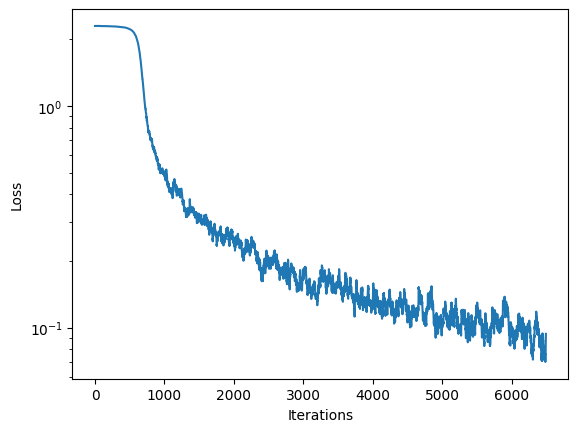

100%|██████████| 938/938 [00:10<00:00, 87.76it/s]


Epoch 7, Loss: 0.0980, Accuracy: 0.9701


{'web': 'https://www.comet.com/api/image/download?imageId=ce774497bea349cbb30446e99e0cd10f&experimentKey=eec45542976d4a33907f56f8eb8452fd',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=ce774497bea349cbb30446e99e0cd10f&experimentKey=eec45542976d4a33907f56f8eb8452fd',
 'imageId': 'ce774497bea349cbb30446e99e0cd10f'}

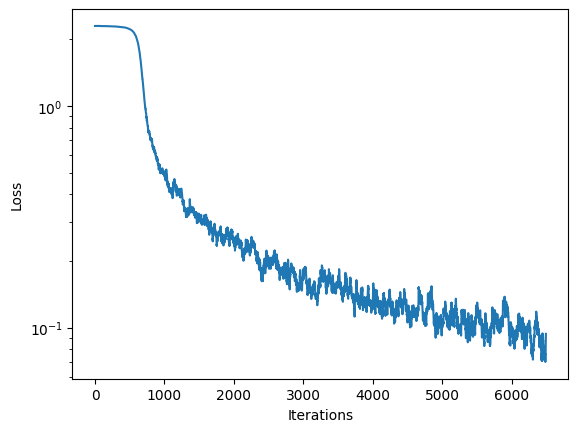

In [22]:
loss_history = mdl.util.LossHistory(smoothing_factor=0.95)  # to record the evolution of the loss
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss', scale='semilogy')

# Initialize new comet experiment
comet_ml.init(project_name="6.s191lab2_part1_CNN")
comet_model_2 = comet_ml.Experiment()

if hasattr(tqdm, '_instances'): tqdm._instances.clear()  # clear if it exists

# Training loop!
cnn_model.train()

for epoch in range(epochs):
    total_loss = 0
    correct_pred = 0
    total_pred = 0

    for idx, (images, labels) in enumerate(tqdm(trainset_loader)):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        logits = cnn_model(images)  # feed images into the model

        # Compute the categorical cross-entropy loss
        loss = loss_function(logits, labels)

        # Log loss
        loss_value = loss.item()
        comet_model_2.log_metric("loss", loss_value, step=idx)
        loss_history.append(loss_value)
        plotter.plot(loss_history.get())

        # Backpropagation
        optimizer.zero_grad()      # reset optimizer gradients
        loss.backward()            # compute gradients
        optimizer.step()           # update model parameters

        # Prediction and metrics
        predicted = torch.argmax(logits, dim=1)
        correct_pred += (predicted == labels).sum().item()
        total_pred += labels.size(0)
        total_loss += loss.item() * images.size(0)

    # Compute metrics for the epoch
    total_epoch_loss = total_loss / total_pred
    epoch_accuracy = correct_pred / total_pred
    print(f"Epoch {epoch + 1}, Loss: {total_epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

comet_model_2.log_figure(figure=plt)


In [23]:
test_loss, test_acc = evaluate(cnn_model, testset_loader, loss_function)

print('Test accuracy:', test_acc)

Test accuracy: 0.9671


In [24]:
test_image, test_label = test_dataset[0]
test_image = test_image.to(device).unsqueeze(0)

# put the model in evaluation (inference) mode
cnn_model.eval()
predictions_test_image = cnn_model(test_image)

In [25]:
print(predictions_test_image)


tensor([[ 3.7938e-03, -1.7139e+00,  4.7512e+00,  4.2974e+00, -6.2340e+00,
         -1.2867e+00, -1.5725e+01,  1.3945e+01,  7.1908e-01,  3.3895e+00]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


In [26]:
predictions_value = predictions_test_image.cpu().detach().numpy()

# Identify the digit with the highest predicted probability
prediction = predictions_value.argmax()  # returns the index of max probability
print(prediction)

7


Label of this digit is: 7


{'web': 'https://www.comet.com/api/image/download?imageId=5d514695b15a4947a3e2bd34cad92532&experimentKey=eec45542976d4a33907f56f8eb8452fd',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=5d514695b15a4947a3e2bd34cad92532&experimentKey=eec45542976d4a33907f56f8eb8452fd',
 'imageId': '5d514695b15a4947a3e2bd34cad92532'}

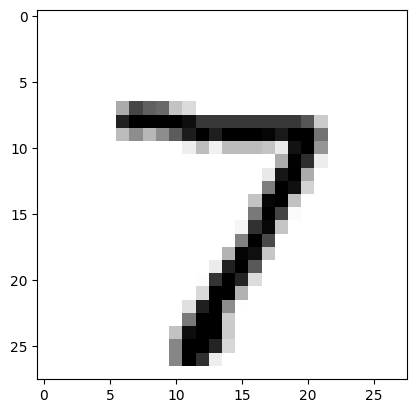

In [27]:
print("Label of this digit is:", test_label)
plt.imshow(test_image[0,0,:,:].cpu(), cmap=plt.cm.binary)
comet_model_2.log_figure(figure=plt)

In [29]:
# Process test set in batches
all_predictions = []
all_labels = []
all_images = []

with torch.no_grad():
    for images, labels in testset_loader:
        # Move images and labels to the same device as the model
        images, labels = images.to(device), labels.to(device)

        outputs = cnn_model(images)

        # Apply softmax to get probabilities from logits
        probabilities = torch.nn.functional.softmax(outputs, dim=1)

        # Get predicted classes
        predicted = torch.argmax(probabilities, dim=1)

        all_predictions.append(probabilities)
        all_labels.append(labels)
        all_images.append(images)

all_predictions = torch.cat(all_predictions)  # Shape: (total_samples, num_classes)
all_labels = torch.cat(all_labels)            # Shape: (total_samples,)
all_images = torch.cat(all_images)            # Shape: (total_samples, 1, 28, 28)

# Convert tensors to NumPy for plotting
predictions = all_predictions.cpu().numpy()
test_labels = all_labels.cpu().numpy()
test_images = all_images.cpu().numpy()


{'web': 'https://www.comet.com/api/image/download?imageId=519c0d24c20c4bb58f0af7f6fec3ef53&experimentKey=eec45542976d4a33907f56f8eb8452fd',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=519c0d24c20c4bb58f0af7f6fec3ef53&experimentKey=eec45542976d4a33907f56f8eb8452fd',
 'imageId': '519c0d24c20c4bb58f0af7f6fec3ef53'}

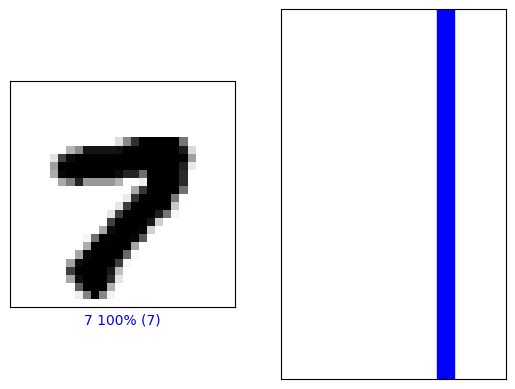

In [30]:
#@title Change the slider to look at the model's predictions! { run: "auto" }

image_index = 79 #@param {type:"slider", min:0, max:100, step:1}
plt.subplot(1,2,1)
mdl.lab2.plot_image_prediction(image_index, predictions, test_labels, test_images)
plt.subplot(1,2,2)
mdl.lab2.plot_value_prediction(image_index, predictions, test_labels)
comet_model_2.log_figure(figure=plt)

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : enthusiastic_snapper_3659
COMET INFO:     url                   : https://www.comet.com/sanjana-jk/6-s191lab2-part1-cnn/eec45542976d4a33907f56f8eb8452fd
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [6566] : (0.009632047265768051, 2.316312074661255)
COMET INFO:   Others:
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=1kZD14qHDwJ5mBjkWhwpqxXuKJ5XIyaSC
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     figures             : 4
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 2
COMET INFO:     os packages    

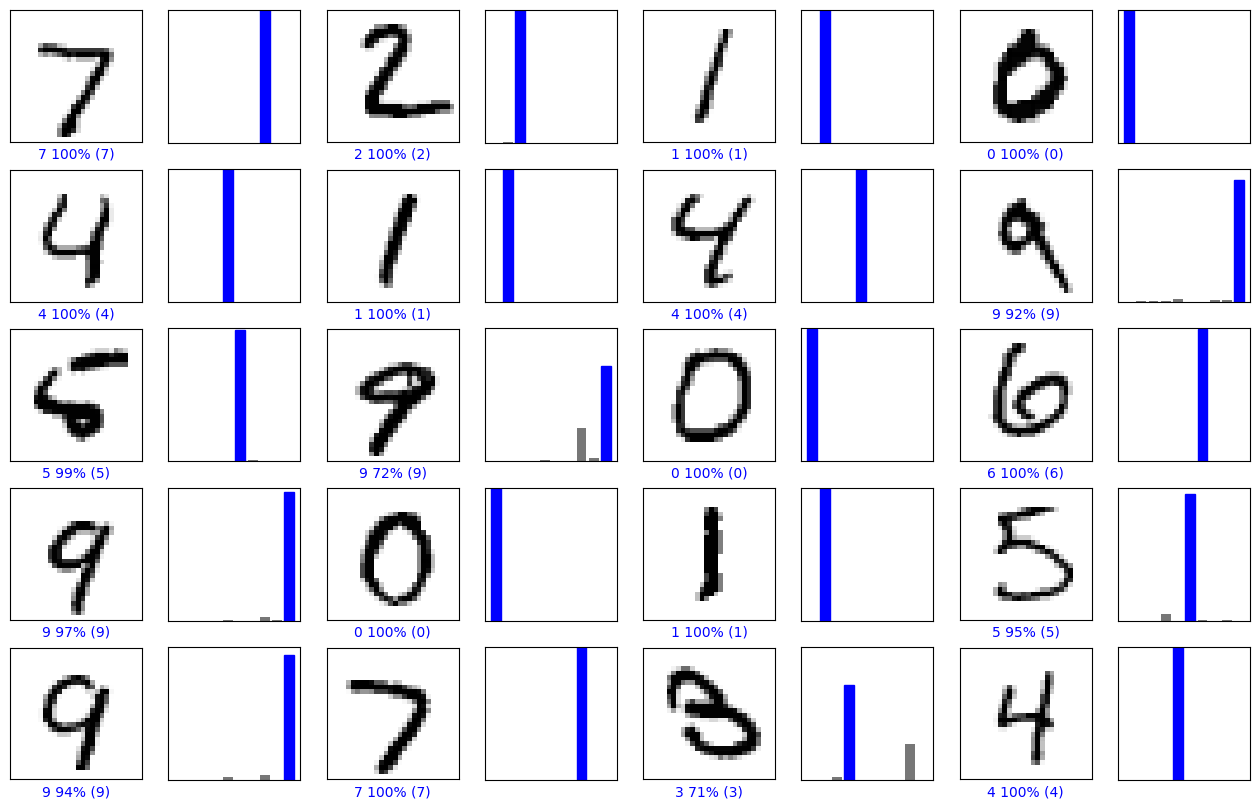

In [31]:
# Plots the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  mdl.lab2.plot_image_prediction(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  mdl.lab2.plot_value_prediction(i, predictions, test_labels)
comet_model_2.log_figure(figure=plt)
comet_model_2.end()